## Packages and Assets

In [13]:
import keras.models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.text import tokenizer_from_json

from keras.utils import pad_sequences
import pandas as pd
import re
import string
import nltk


In [14]:
model = keras.models.load_model('../../assets/lstm_assets/lstm_model')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 11, 300)           3127800   
                                                                 
 bidirectional_2 (Bidirectio  (None, 11, 128)          186880    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 3,417,756
Trainable params: 289,956
Non-

In [15]:
# Load the tokenizer from the file
with open('../../assets/lstm_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    word_index = tokenizer.word_index

## Functions

In [16]:
def transformDocument(df, column_name, language):
    stop_words = usingStopwords(language)
    # 1. Aplicar preprocessamento nos títulos e textos completos
    if language == 'pt':
        # Substituir símbolos importantes
        df[column_name] = df[column_name].map(lambda s: s.replace('-feira', ''))
        df[column_name] = df[column_name].map(lambda s: s.replace('+', 'mais '))
        df[column_name] = df[column_name].map(lambda s: s.replace('-', 'menos '))
        df[column_name] = df[column_name].map(lambda s: s.replace('%', ' por cento'))
        df[column_name] = df[column_name].map(lambda s: removeStopwords(s, stop_words))

    elif language == 'en':
        df[column_name] = df[column_name].map(lambda s: s.replace('-', 'less'))
        df[column_name] = df[column_name].map(lambda s: s.replace('+', 'plus '))
        df[column_name] = df[column_name].map(lambda s: s.replace('%', ' percent'))
        df[column_name] = df[column_name].map(lambda s: removeStopwords(s, stop_words))

    else:
        pass

    df[column_name] = df[column_name].map(lambda s: s.replace('R$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('U$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('US$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('S&P 500', 'spx'))

    # Transformar em String e Letras Minúsculas nas Mensagens
    df[column_name] = df[column_name].map(lambda s:
                                              normalizarString(s))

    # Remover Pontuações
    # Remover Pontuações
    df[column_name] = df[column_name].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

    # Remover Emojis
    df[column_name] = df[column_name].map(lambda s: removeEmojis(s))

    # Quebras de Linha desnecessárias
    df[column_name] = df[column_name].map(lambda s: s.replace('\n', ' '))

    # Remover aspas duplas
    df[column_name] = df[column_name].map(lambda s: s.replace('\"', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('“', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('”', ''))

    # Remover valores
    df[column_name] = df[column_name].map(lambda s: removeValores(s))

    # Espaços desnecessários
    df[column_name] = df[column_name].map(lambda s: s.strip())
    return df

def removeEmojis(sentence):
    "Remoção de Emojis nas mensagens de texto."

    # Padrões dos Emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', sentence)

def removeValores(sentence):
    new_sentece = ''

    for token in sentence.split():
        if token.isdigit():
            token = '<NUM>'
        new_sentece += ' {}'.format(token)

    return new_sentece

def usingStopwords(language):
    stop_words = []

    nltk.download('stopwords')

    if language == 'pt':
        stop_words = nltk.corpus.stopwords.words('portuguese')
    elif language == 'en':
        stop_words = nltk.corpus.stopwords.words('english')

    return stop_words

def removeStopwords(text, stop_words):
    tokens = []
    for word in text.split():
        if word not in stop_words:
            tokens.append(word)

    text = ' '.join(tokens)
    return text

def normalizarString(text):
    """
    Função para retirar acentuações e converter para minúscula
    :param text:
    :return text_normalizado
    """
    import unicodedata

    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text.lower())

## Loading test data

In [17]:
test_raw = pd.read_csv('../../assets/data/splits/test/raw.csv')
test_raw

,title,tags,link,label
0,IRB Brasil (IRBR3) apresenta representação cri...,"['IRB Brasil', 'IRBR3']",https://www.sunoresearch.com.br/noticias/irb-b...,0
1,Títulos indexados do Tesouro Direto apresentam...,"['Tesouro Direto', 'Tesouro Nacional']",https://www.sunoresearch.com.br/noticias/tesou...,0
2,"Guide Investimentos retira Petrobras, Gerdau e...","['BB Seguridade', 'Braskem', 'Comprar ou vende...",https://www.moneytimes.com.br/guide-retira-pet...,1
3,Justiça extingue ação de hipoteca judiciária d...,"['Commodities', 'Empresas', 'Petrobras', 'Petr...",https://www.moneytimes.com.br/justica-extingue...,1
4,"Mesmo com produção da Opep em queda, sauditas ...","['OPEP', 'petróleo']",https://www.sunoresearch.com.br/noticias/mesmo...,0
...,...,...,...,...
1791,Metaverso: Veja as 4 ações que você precisa te...,"['COE', 'Comprar ou vender?', 'Facebook', 'Int...",https://www.moneytimes.com.br/metaverso-veja-a...,3
1792,Promotores da Itália pedem que donos da Techin...,"['Empresas', 'Internacional', 'Petrobras', 'Re...",https://www.moneytimes.com.br/promotores-da-it...,1
1793,Rali do minério pode esfriar por riscos na Chi...,"['Austrália', 'Bloomberg', 'Brasil', 'Brumadin...",https://www.moneytimes.com.br/rali-do-minerio-...,2
1794,Boletim Focus: mercado reduz previsão para PIB...,"['Banco Central', 'Boletim Focus', 'inflação',...",https://www.sunoresearch.com.br/noticias/bolet...,0


In [18]:
test_preprocessed = transformDocument(test_raw, 'title', 'pt')

X_test = test_preprocessed.title
y_test = test_preprocessed.to_numpy()[:, -1]

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=11, padding='post', truncating='post')
test_padded

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guilherme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array([[ 223,   14,  509, ..., 4022,    0,    0],
       [ 101,  877,   97, ...,    0,    0,    0],
       [ 307,   81,  628, ...,    0,    0,    0],
       ...,
       [1602,   15,   29, ...,    0,    0,    0],
       [ 443,  418,   32, ...,    0,    0,    0],
       [1216,    6,    2, ..., 1062,  244,    0]])

### Functions

In [19]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text

def show_confusion_matrix(cm):
        print("Confusion Matrix")
        plt.figure(figsize=(10, 7))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.show()

In [20]:
index_word = index2word(word_index)

In [21]:
pred_prob = model.predict(test_padded)

57/57 [==============================] - 2s 7ms/step


In [22]:
# y_pred = [1 if p > 0.5 else 0 for p in pred_prob]
y_pred = np.argmax(pred_prob, axis=1)

In [23]:
df_results = pd.DataFrame()
X_test = list(X_test)
y_test = list(y_test)
df_results['sequence'] = test_sequences
df_results['X_test'] = X_test
df_results['seq2text'] = df_results['sequence'].apply(lambda x: seq2text(x, index_word))
df_results['y_pred'] = y_pred
df_results['y_true'] = y_test
df_results

,sequence,X_test,seq2text,y_pred,y_true
0,"[223, 14, 509, 277, 1, 2743, 16, 1904, 4022]",irb brasil irbr3 apresenta representacao crimi...,"[irb, brasil, irbr3, apresenta, <OOV>, crimina...",0,0
1,"[101, 877, 97, 103, 572, 520, 94, 61]",titulos indexados tesouro direto apresentam es...,"[titulos, indexados, tesouro, direto, apresent...",0,0
2,"[307, 81, 628, 3, 400, 165, 17, 91]",guide investimentos retira petrobras gerdau it...,"[guide, investimentos, retira, petrobras, gerd...",1,1
3,"[107, 3013, 30, 1, 10423, 1340, 105, 3]",justica extingue acao hipoteca judiciaria prev...,"[justica, extingue, acao, <OOV>, judiciaria, p...",1,1
4,"[1464, 37, 975, 12, 4794, 3722, 152]",mesmo producao opep queda sauditas batem recorde,"[mesmo, producao, opep, queda, sauditas, batem...",2,0
...,...,...,...,...,...
1791,"[2973, 36, 2, 9, 806, 124, 83, 4136, 7]",metaverso veja <NUM> acoes precisa ter segundo...,"[metaverso, veja, num, acoes, precisa, ter, se...",2,3
1792,"[1, 2249, 873, 3862, 1, 1, 361, 3540, 3]",promotores italia pedem donos techint julgados...,"[<OOV>, italia, pedem, donos, <OOV>, <OOV>, ca...",1,1
1793,"[1602, 15, 29, 1, 673, 60, 6, 3298]",rali minerio pode esfriar riscos china diz aus...,"[rali, minerio, pode, <OOV>, riscos, china, di...",2,2
1794,"[443, 418, 32, 86, 390, 82, 2]",boletim focus mercado reduz previsao pib <NUM>,"[boletim, focus, mercado, reduz, previsao, pib...",0,0


### Metrics

In [24]:
# accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# precision = precision_score(average='macro', y_true=y_test, y_pred=y_pred)
# recall = recall_score(average='macro', y_true=y_test, y_pred=y_pred)
# f1 = f1_score(average='macro', y_true=y_test, y_pred=y_pred)
# cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.65      0.93      0.77       590
           1       0.85      0.77      0.81       623
           2       0.92      0.69      0.79       395
           3       0.88      0.44      0.59       188

    accuracy                           0.77      1796
   macro avg       0.83      0.71      0.74      1796
weighted avg       0.81      0.77      0.77      1796

Confusion Matrix


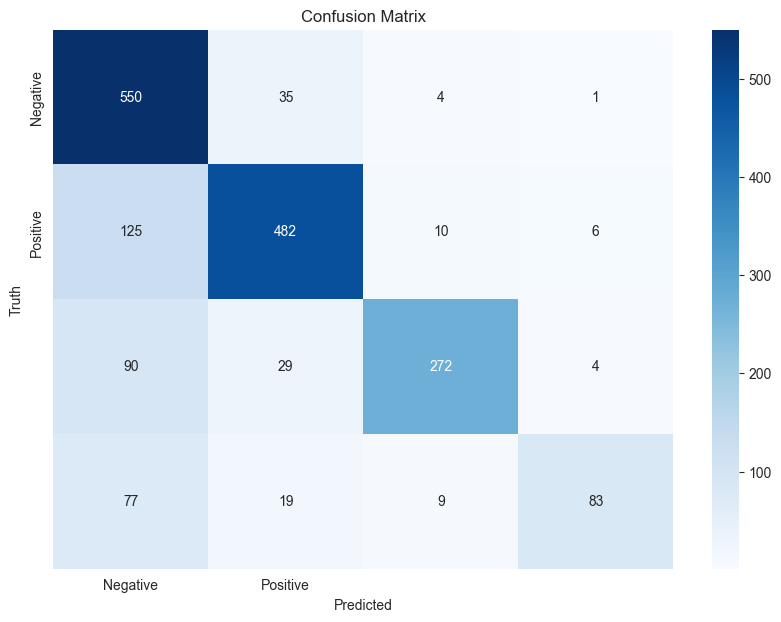

In [25]:
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
show_confusion_matrix(cm)